# 事前準備

以下を実行して、外部ファイルをダウンロードしてください。   
**このセルはColaboratoryを起動するたびに必要となります**   

In [ ]:
import urllib.request
import os

os.makedirs('fig', exist_ok=True)

##################################
### Colaboratoryのみ以下を実行 ###
##################################
import sys
if 'google.colab' in sys.modules:
    !pip install mpl_finance

# ウェブデータ処理４：時系列データの表現と可視化２

時系列データは、そのままの状態だと人間にとって見づらいだけでなく、機械学習を適用する際にもよい結果を得ることが難しい場合が多いです。  
元のデータから、そこで起こっている現象をわかりやすく説明するような情報を取り出すことを「特徴抽出」と言います。

株価履歴を使って、時系列データから特徴を抽出してみましょう。

## 1. 前資料の再現

前の資料でデータの読み込みとローソク足チャートの描画までをやりました。   
そこまでを再現します。

### 1.1 株価データの読み込み（csvから）

まずデータを読み込みましょう。  
このデータは2018年1月1日～2019年3月31日までの米国でのトヨタの株価データです。

In [ ]:
import pandas as pd

sdf = pd.read_csv('TM_20180101-20190331_stock.csv')
sdf['date'] = pd.to_datetime(sdf['date']) # 'date'キーの値は日付を表す文字列なので、to_datetimeを適用してdatetime64型に変換
sdf.set_index('date', inplace=True) # 次に、set_index()メソッドで'date'キーの列をインデックスに指定する。
sdf.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,123.4915,124.4606,123.2396,124.4025,83545
2018-01-03,124.7029,126.2104,124.5866,126.1081,162349
2018-01-04,127.2516,128.0754,127.2419,128.0754,161798
2018-01-05,128.9960,129.7325,128.9669,129.7228,135309
2018-01-08,129.8391,130.6241,129.4902,130.6047,131364


### 1.2 ローソク足チャートの描画
dataFrame形式の株価データを加工し、mpl_financeモジュールを利用してローソク足チャートを描画します。

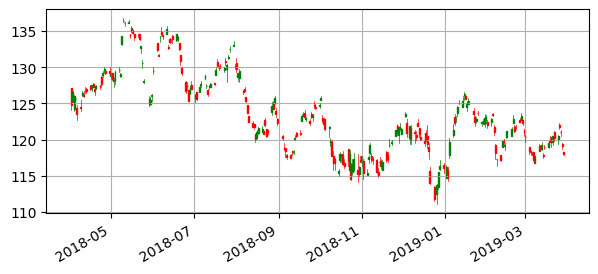

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.dates as mdates
from datetime import datetime

start = datetime(2018, 4, 1)
end = datetime(2019, 3, 31)

ohlc = sdf.loc[start:end, ['open', 'high', 'low', 'close']] # 出来高は単位が違うので除く
ohlc.index = mdates.date2num(ohlc.index.to_pydatetime()) # indexをdatetime形式から数値に変換

data = ohlc.reset_index().values # matrixに変換

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot()
mpl_finance.candlestick_ohlc(ax, data, width=0.7, colorup='g', colordown='r')
ax.grid()  # グリッド表示
locator = mdates.AutoDateLocator() # x軸(xaxis)を日付(Date)単位(major)のラベルにする(set)
#locator = mdates.DayLocator() # x軸を日単位のラベルにする
#locator = mdates.MonthLocator() # x軸を月単位のラベルにする
#locator = mdates.YearLocator() # x軸を年単位のラベルにする
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
fig.autofmt_xdate() # X軸の日付ラベルが見やすくなるよう回転
plt.savefig('fig/WebDataProcessing4-1.png') # 図を画像として保存

このように、1年以上のデータをグラフ化すると、日ごとのデータ（日足データ）では細かすぎて見づらいですね。  
そこで、日足を週足にまとめることを考えましょう。  
まとめるということは、すなわち、サンプルを記録する頻度を減らすということです。   
時系列データに対してサンプルの記録頻度を減らすことを**ダウンサンプリング**と呼びます。

## 2. ダウンサンプリング

与えられた株価データは1日ごとの値（日足）です。   
ですが、半年の変化を見たいとき、日足でローソクチャートを出しても何が何だか分かりませんね。   
そこで、週足データに変換したいと思います。

１週間分の日足データとその週の週足データは次のような関係になっています。

| key | 処理 |
| ---- | ---- |
| open | 最初の値 (first) |
| high | 最大値 (max) |
| low | 最小値 (min) |
| close | 最後の値 (close) |
| volume | 総和 (sum) |

ここで挙げた処理のような一般的な集計は、DataFrame形式では一気に行うことができます。   
たとえばsdf.mean()とすれば、各ラベルのデータについて平均値が計算されます。

In [ ]:
print(sdf.mean()) # 平均値を出力

open         124.903217
high         125.450721
low          124.211740
close        124.826840
volume    192578.769231
dtype: float64


ラベルごとに異なる処理を行う場合は、その対応関係をあらかじめ辞書として用意しておき、それを`agg`関数でまとめて適用することもできます。  
ただし、firstやlastなどは、下の関数resampleで区間に分けてからしか計算できませんので、
ここではaggを試すため、ラベルごとに平均値（mean)をとってみましょう


In [ ]:
d_ohlcv = {'open': 'mean',
           'high': 'mean',
           'low': 'mean',
           'close': 'mean',
           'volume': 'mean'}
sdf.agg(d_ohlcv)

open         124.903217
high         125.450721
low          124.211740
close        124.826840
volume    192578.769231
dtype: float64

この計算を週単位でやればいいということですね。

DataFrameを特定の単位ごとにまとめるにはresampleを使います。   
ここでは間隔を週とし、週の開始日は毎週月曜としましょう。   
また、開始日をその週に含めるため`closed = 'left'`   
ラベルの日付に月曜日の日を使うため`label = 'left'`とします。

resampleしたDataFrameには以下の処理が実行できます。  

| 関数|処理内容 |
| --- | --- |
| count | 数を数える |
| nunique | ユニークな要素の数 |
| first | 最初の値 |
| last |  最後の値 |
| max | 最大値 |
| mean | 平均値 |
| median | 中央値 |
| min | 最小値 |
| ohlc | ohlcデータ |
| prod | 積 |
| size | サイズ |
| std | 標準偏差 |
| sum | 和 |
| var | 分散 |
| quantile | 分位数・パーセンタイル |


In [ ]:
d_ohlcv = {'open': 'first',
           'high': 'max',
           'low': 'min',
           'close': 'last',
           'volume': 'sum'}

sdf_w = sdf.resample('W-MON',# ダウンサンプリングの単位をWeekにし、その開始を月曜日（MON)にする
                     closed='left', # 開始と終了のどちらを含めるか（開始を含める）
                     label='left' # 開始と終了のどちらの日時をラベルにするか
                    ).agg(d_ohlcv) # DataFrame形式
sdf_w.head()

,open,high,low,close,volume
date,,,,,
2018-01-01,123.4915,129.7325,123.2396,129.7228,543001
2018-01-08,129.8391,133.0468,128.9766,132.9596,951092
2018-01-15,134.8978,136.6325,133.3375,135.5277,997739
2018-01-22,134.6749,135.4211,133.4538,135.2466,1241711
2018-01-29,135.6246,136.1188,132.3684,132.3975,1114533


ローソク足チャートを描画するために、DataFrameを二次元配列のリストに変換します。   
これはWebDataProcessing3.ipynbでやった処理と同じです。

In [ ]:
from datetime import datetime
import matplotlib.dates as mdates

start = datetime(2018, 4, 1)
end = datetime(2019, 3, 31)

ohlc = sdf_w.loc[start:end, ['open', 'high', 'low', 'close']] # 出来高は単位が違うので除く
ohlc.index = mdates.date2num(ohlc.index.to_pydatetime()) # indexをdatetime形式から数値に変換
data = ohlc.reset_index().values # matrixに変換

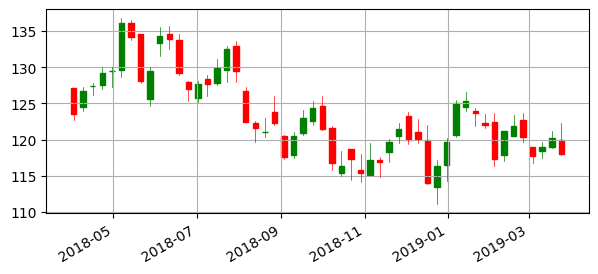

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.dates as mdates

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot()
mpl_finance.candlestick_ohlc(ax, data, width=4, colorup='g', colordown='r')
ax.grid()  # グリッド表示
locator = mdates.AutoDateLocator() # x軸(xaxis)を日付(Date)単位(major)のラベルにする(set)
#locator = mdates.DayLocator() # x軸を日単位のラベルにする
#locator = mdates.MonthLocator() # x軸を月単位のラベルにする
#locator = mdates.YearLocator() # x軸を年単位のラベルにする
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
fig.autofmt_xdate() # X軸の日付ラベルが見やすくなるよう回転
plt.savefig('fig/WebDataProcessing4-2.png') # 図を画像として保存

## 3. n項移動平均

移動平均もまた時系列データおいて一般的な概念です。   
nは区間数です。

株価はその日その日でランダムに変わるのではなく、長期的に見れば山や谷があり、上がる傾向や下がる傾向があります（これらをそれぞれ上昇トレンド、下降トレンドと呼ぶそうです）。   
このような傾向をとらえるためには、その日を含め、過去の一定期間の株価の平均を可視化してみることが有効です。   
常に過去n個分（データによってn日分やn週間分など）の平均値からなるデータをn項移動平均と呼びます。   
過去何日分を取るのかは人によるようですが、5日間、25日間、50日間などがよく使われるようです。   
ここで、この5日間には株式市場の休場日（すなわち株価データが欠落している日）は含まないのが一般的なようです。

日足データに対し、各時点で、その時点から過去の$n$個分のデータを切り出すには`rolling`という関数が利用できます。   
ここでは、長さ5個、25個、50個の時系列データを切り出しましょう。   
さらに、そのそれぞれの時系列データに対し、関数`mean()`で平均値に変換しましょう。   
これにより、各時点に対し1つの平均値が計算されます。

In [ ]:
sdf['mean-5D'] = sdf.loc[:, 'close'].rolling(5).mean()
sdf['mean-25D'] = sdf.loc[:, 'close'].rolling(25).mean()
sdf['mean-50D'] = sdf.loc[:, 'close'].rolling(50).mean()
mean_labels = ['mean-5D', 'mean-25D', 'mean-50D']

ローソク足チャートの上に移動平均の折れ線グラフを重ねて描画してみましょう。

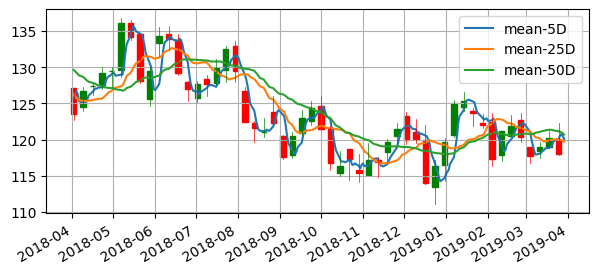

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.dates as mdates
from datetime import datetime
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converterをリセット

fig = plt.figure(figsize=(7, 3)) # figure(図を配置する画面)のサイズを指定
ax = plt.subplot()

ax.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-5D'])
ax.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-25D'])
ax.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-50D'])
ax.legend(mean_labels) # 凡例を描画
mpl_finance.candlestick_ohlc(ax, data, width=4, colorup='g', colordown='r')
ax.grid() # グリッドを描画

locator = mdates.MonthLocator() # x軸を月単位のラベルにする
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
fig.autofmt_xdate() # X軸の日付ラベルが見やすくなるよう回転
plt.savefig('fig/WebDataProcessing4-3.png') # 図を画像として保存

rollingで切り出した各時系列データに対する処理は、resampleと同じものもあり、違うものもあります。   
くわしくは[こちら](https://pandas.pydata.org/pandas-docs/stable/reference/window.html)を見てください。

## 4. グラフを並べて表示

### 4.1 出来高グラフを追加

出来高グラフを追加してみましょう。   
出来高とは、取引が成立した株の数で、棒グラフで表すのが普通です。   
これを上で生成したグラフの下に追加します。

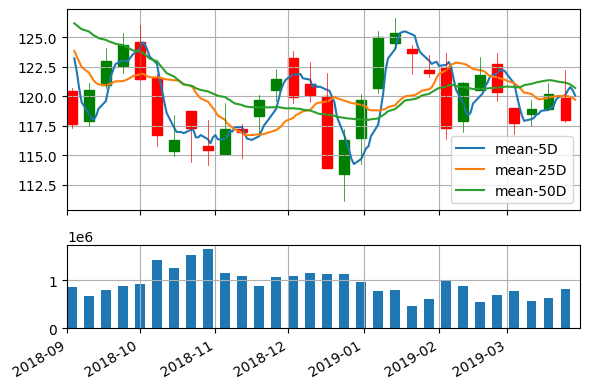

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # コンバータをリセット

fig = plt.figure(figsize=(6, 4))

# 1つのfigureを分割し、そのいくつかの領域を一つのグラフ領域に指定する処理
G = gridspec.GridSpec(3,1) # figureを縦３つ、横１つに分割(Gはリストであることに注意)
ax0 = plt.subplot(G[:2,0]) # 縦0～１（２つ分）、横0(１つ分)の領域をax0とする
ax1 = plt.subplot(G[2,0]) # 縦2 (１つ分)、横０（１つ分）の領域をax1とする

start = datetime(2018, 9, 1)
end = datetime(2019, 3, 31)

ohlc = sdf_w.loc[start:end, ['open', 'high', 'low', 'close']] # 出来高は単位が違うので除く
ohlc.index = mdates.date2num(ohlc.index.to_pydatetime()) # indexをdatetime形式から数値に変換

data = ohlc.reset_index().values # matrixに変換

ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-5D'])
ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-25D'])
ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-50D'])
ax0.legend(mean_labels) # 凡例を描画
mpl_finance.candlestick_ohlc(ax0, data, width=4, colorup='g', colordown='r')
ax0.grid() # グリッドを描画
locator = mdates.MonthLocator() # x軸を月単位のラベルにする
ax0.xaxis.set_major_locator(locator)
ax0.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax0.set_xlim([start, end])

ax1.bar(sdf_w[start:end].index, sdf_w.loc[start:end, 'volume'], width = 4.0)
ax1.grid()
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax1.set_xlim([start, end])

fig.autofmt_xdate() # X軸の日付ラベルが見やすくなるよう回転
fig.tight_layout() # 図がはみ出さないようにレイアウト
plt.show()

### 4.2 移動平均乖離率を追加

現在の株価が移動平均から何％ずれているのかを示す指標を「移動平均乖離率」と呼びます。   
移動平均乖離率は以下のようにして計算できます。

[移動平均乖離率] = ([終値] - [n項移動平均]) / [n項移動平均] * 100


In [ ]:
sdf['diff-5D'] = (sdf['close'] - sdf['mean-5D'])/sdf['mean-5D'] * 100
sdf['diff-25D'] = (sdf['close'] - sdf['mean-25D'])/sdf['mean-25D'] * 100
sdf['diff-50D'] = (sdf['close'] - sdf['mean-50D'])/sdf['mean-50D'] * 100
diff_labels = ['diff-5d', 'diff-25D', 'diff-50D']

上の図に移動平均乖離率の棒グラフも追加してみましょう。

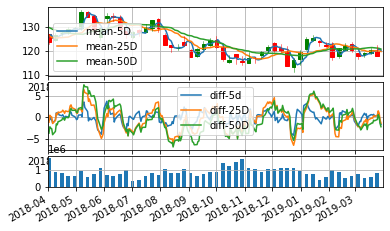

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import mpl_finance
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

fig = plt.figure(figsize=(6, 4))
G = gridspec.GridSpec(6,1)
ax0 = plt.subplot(G[:2,0]) # 1つ目のグラフの位置指定
ax1 = plt.subplot(G[2:4,0]) # 2つ目のグラフの位置指定
ax2 = plt.subplot(G[4:5,0]) # 3つ目のグラフの位置指定

start = datetime(2018, 4, 1)
end = datetime(2019, 3, 31)

ohlc = sdf_w.loc[start:end, ['open', 'high', 'low', 'close']] # 出来高は単位が違うので除く
ohlc.index = mdates.date2num(ohlc.index.to_pydatetime()) # indexをdatetime形式から数値に変換

data = ohlc.reset_index().values # matrixに変換

ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-5D'])
ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-25D'])
ax0.plot(sdf[start:end].index, sdf.loc[start:end, 'mean-50D'])
ax0.legend(mean_labels) # 凡例を描画
mpl_finance.candlestick_ohlc(ax0, data, width=4, colorup='g', colordown='r')
ax0.grid() # グリッドを描画
ax0.tick_params(labelbottom="off") # x軸の削除
ax0.set_xlim([start, end])

ax1.plot(sdf[start:end].index, sdf.loc[start:end, 'diff-5D'])
ax1.plot(sdf[start:end].index, sdf.loc[start:end, 'diff-25D'])
ax1.plot(sdf[start:end].index, sdf.loc[start:end, 'diff-50D'])
ax1.legend(diff_labels) # 凡例を描画
ax1.grid()  # グリッド表示
ax1.tick_params(labelbottom="off") # x軸の削除
ax1.set_xlim([start, end])

ax2.bar(sdf_w[start:end].index, sdf_w.loc[start:end, 'volume'], width=4.0)
ax2.grid()
locator = mdates.MonthLocator() # x軸を月単位のラベルにする
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax2.set_xlim([start, end])
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')# 軸を右揃えにして斜めに
plt.savefig('fig/WebDataProcessing4-4.png') # 図を画像として保存